In [2]:
import numpy as np
import sys
import re
import os
import cygnus_lib as cy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
#import mylib as my
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line, resize, rescale)
import scipy.ndimage
from skimage.transform import hough_circle, hough_circle_peaks
from scipy.stats import norm
import scipy.stats as stats


import pandas as pd
import pickle
import time
from IPython import display

%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
plt.rcParams['font.serif'] = ['Bitstream Vera Sans']
x_resolution = y_resolution = 2048
from itertools import combinations

#  Clustering Th setted nsigma over ped

# of Image Files: 100


/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Pedestal mean: 98.85, sigma: 1.07, over th. (150) 85
Sigma mean: 2.51, sigma: 2.13, over th. (50) 13
Clustering time: 1.04 s


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


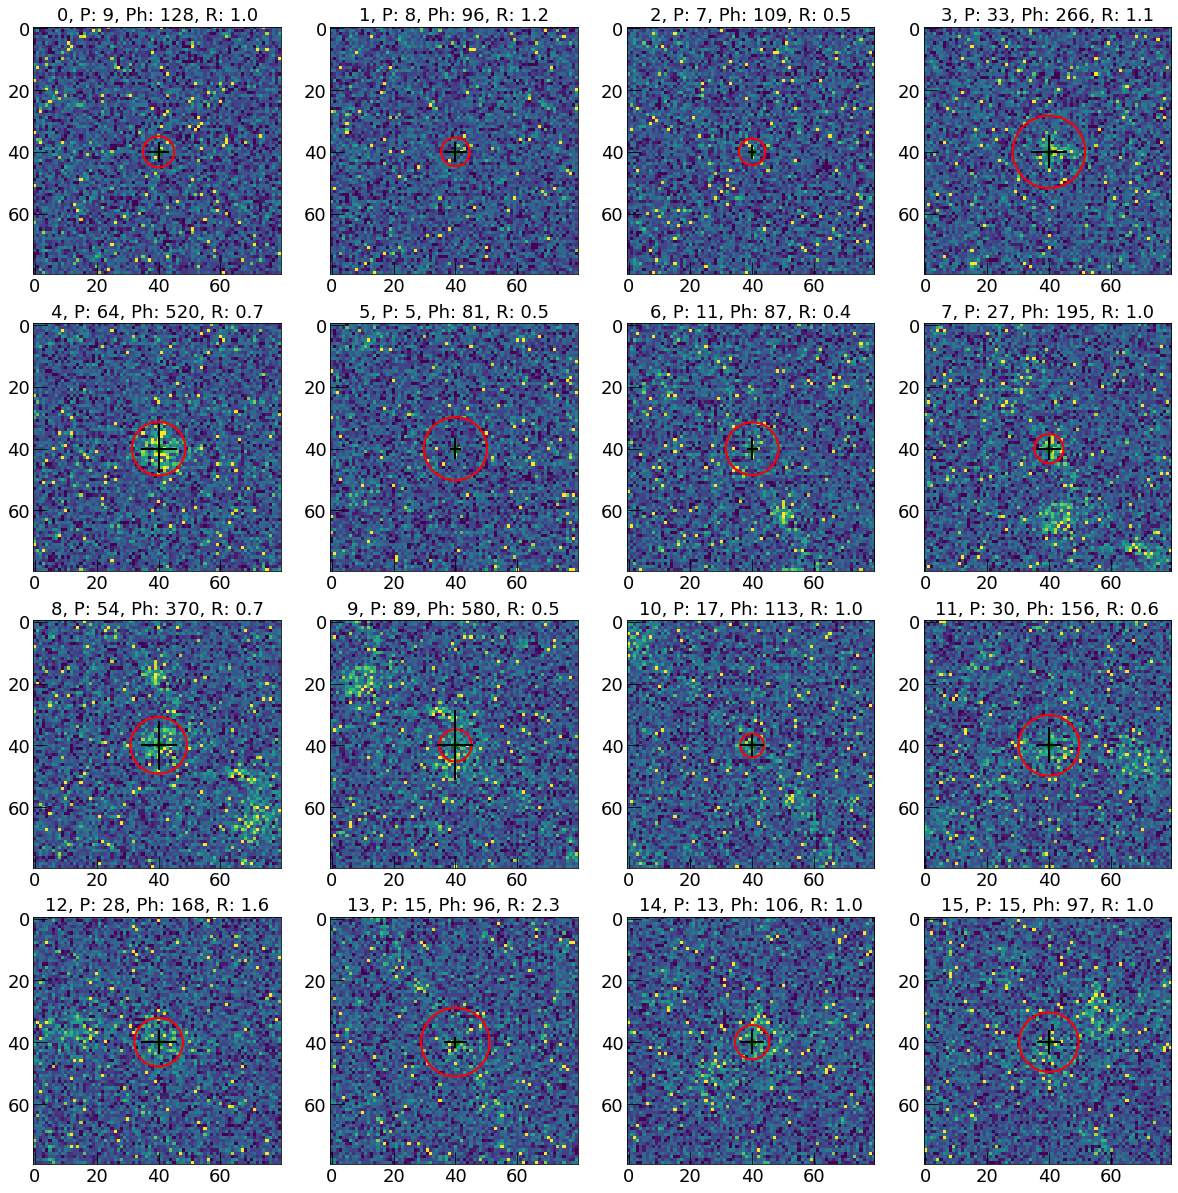

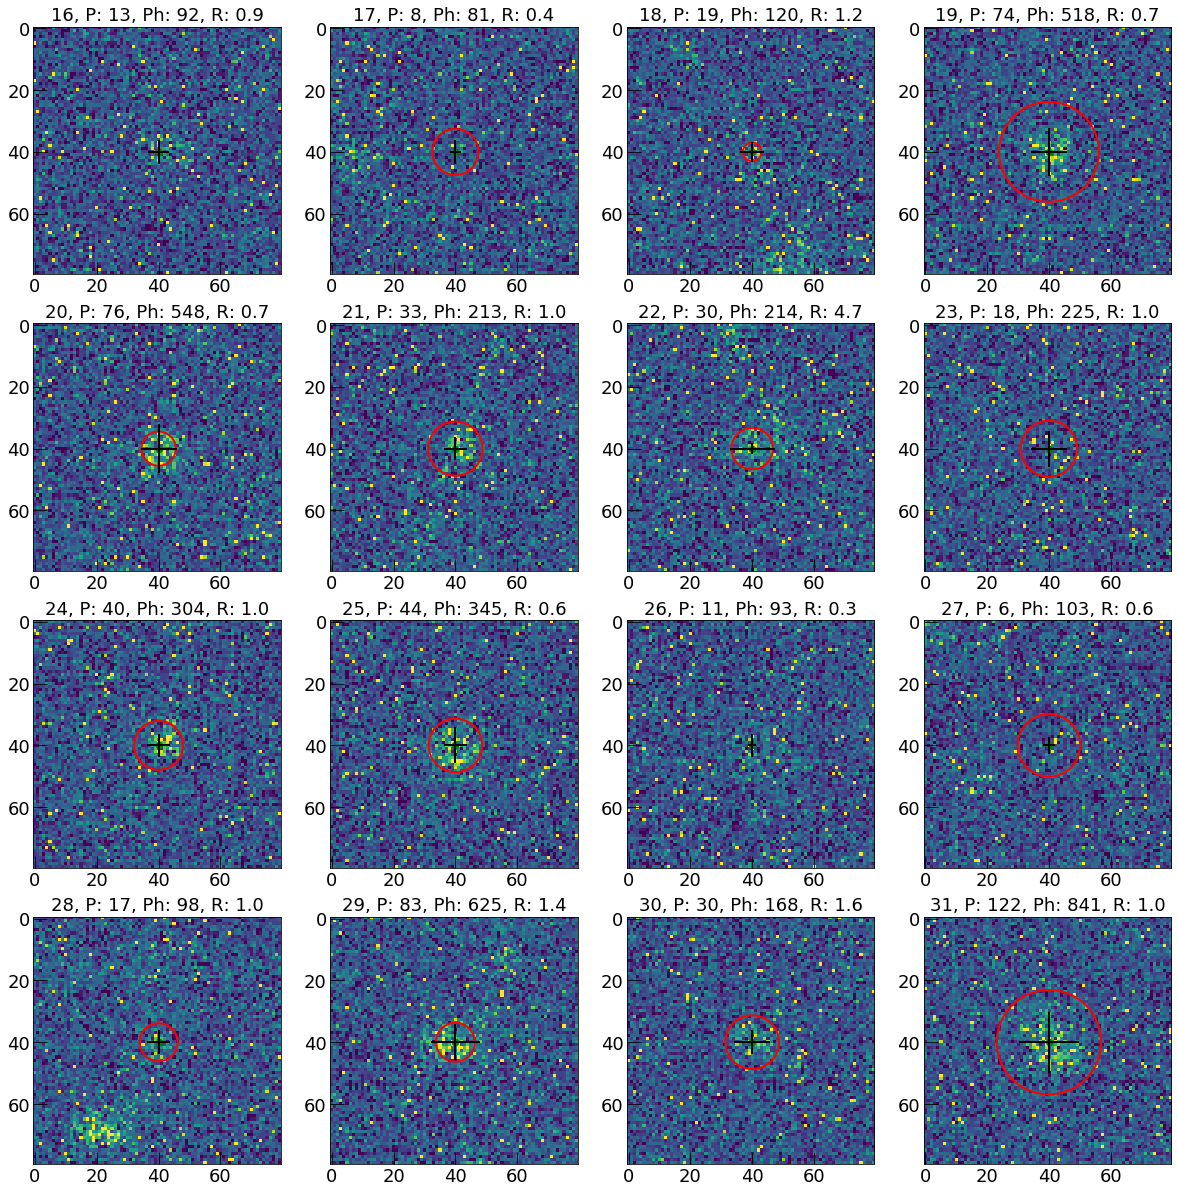

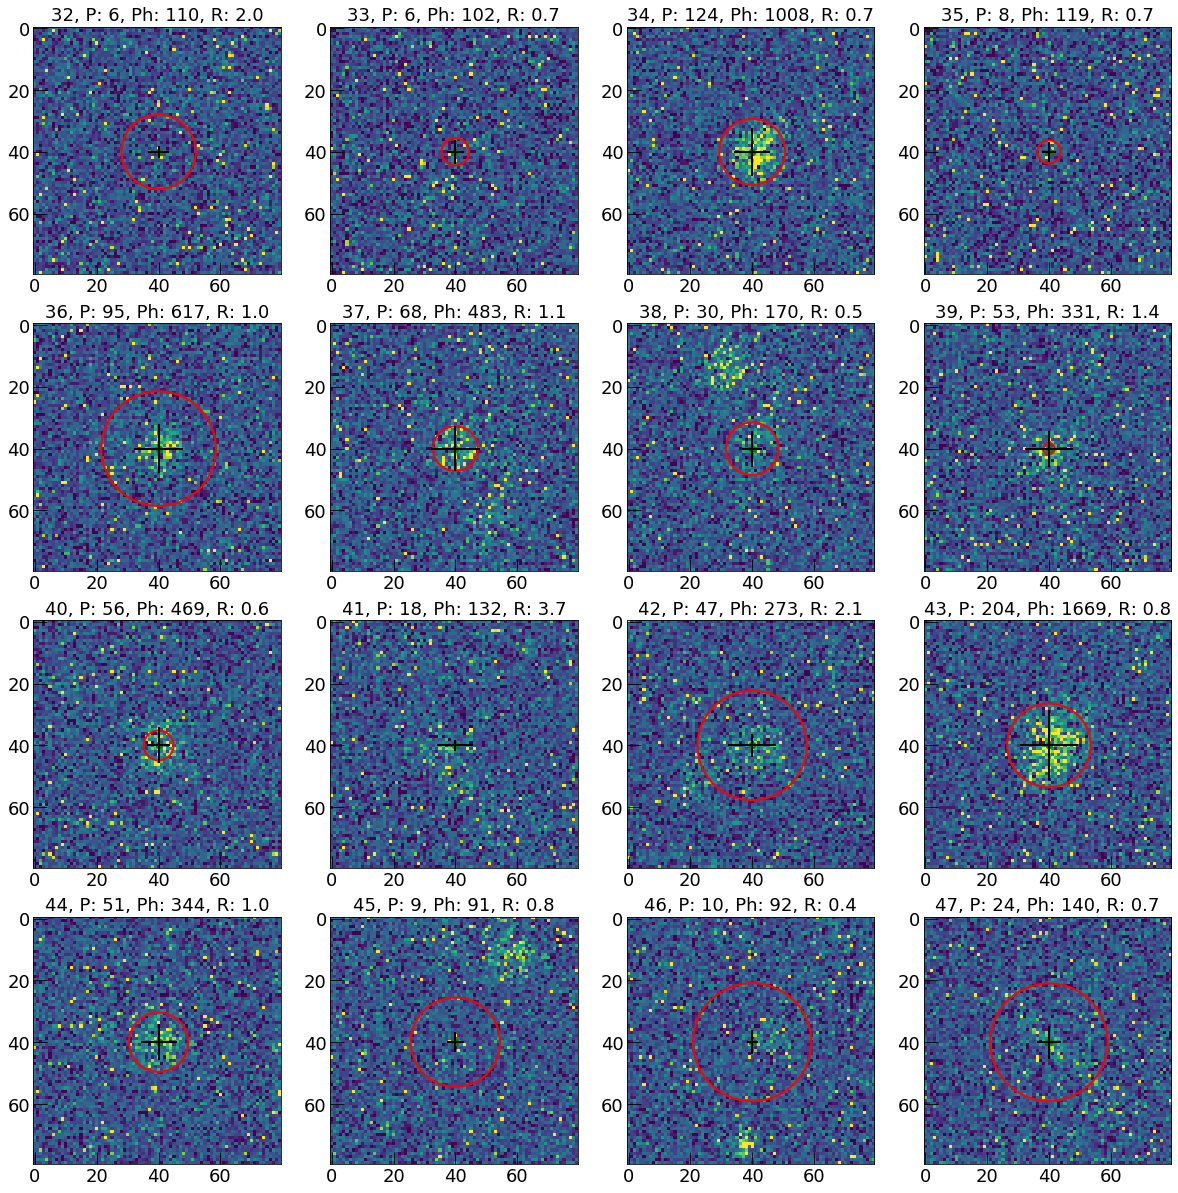

>>> ERROR: Image: 0, cluster index: 54, size: 2
Cluster Size: 20
Iamege: 0, Spot: 57, Light: 414507178 bck: 414667403


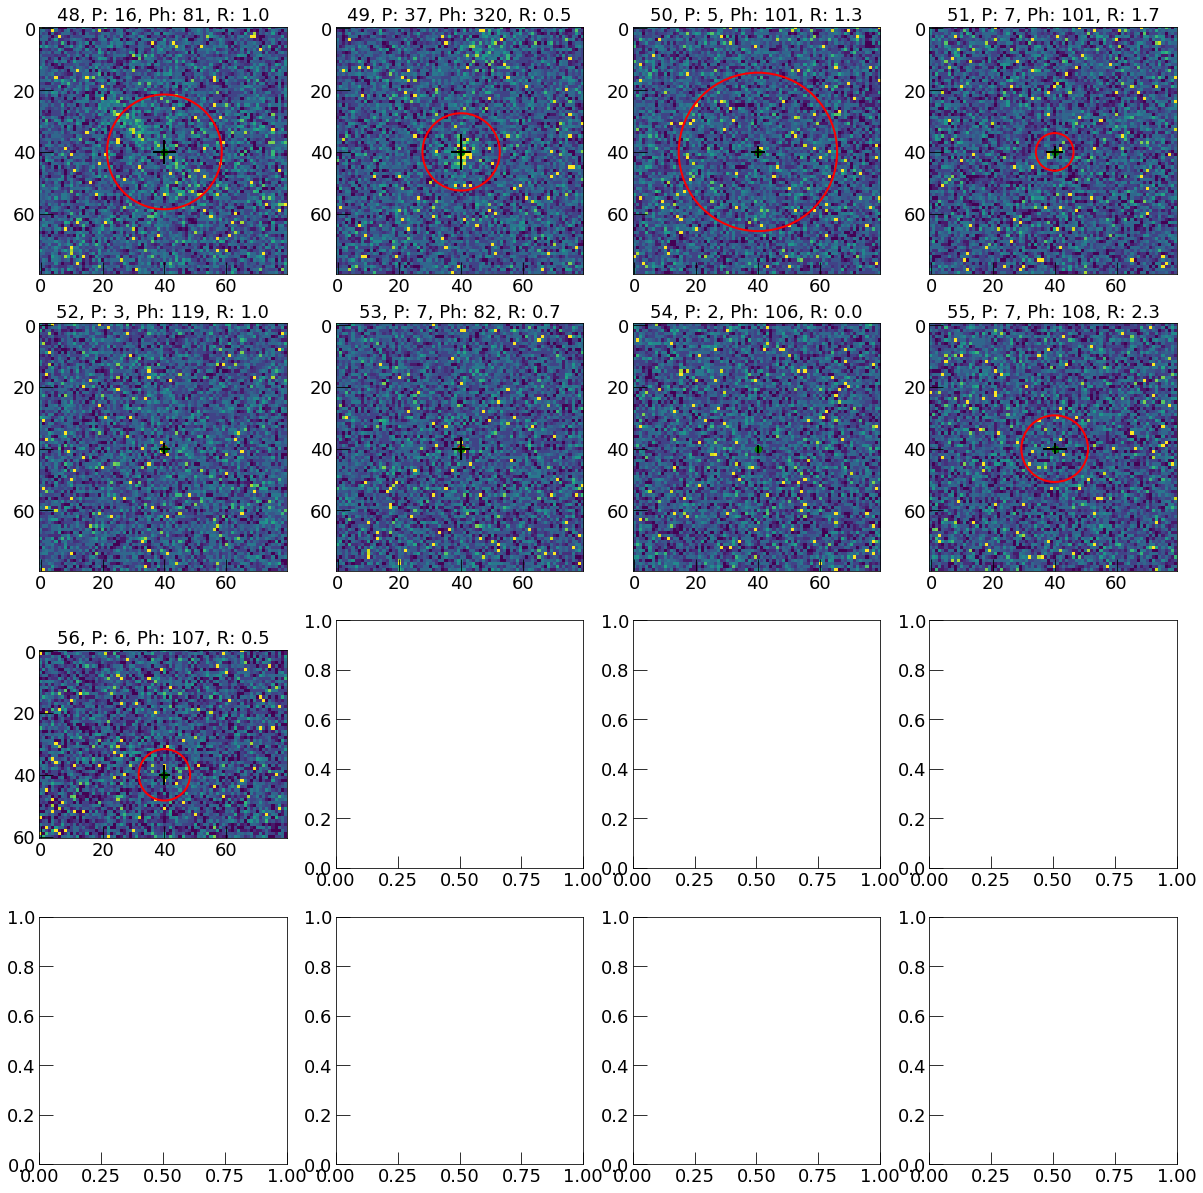

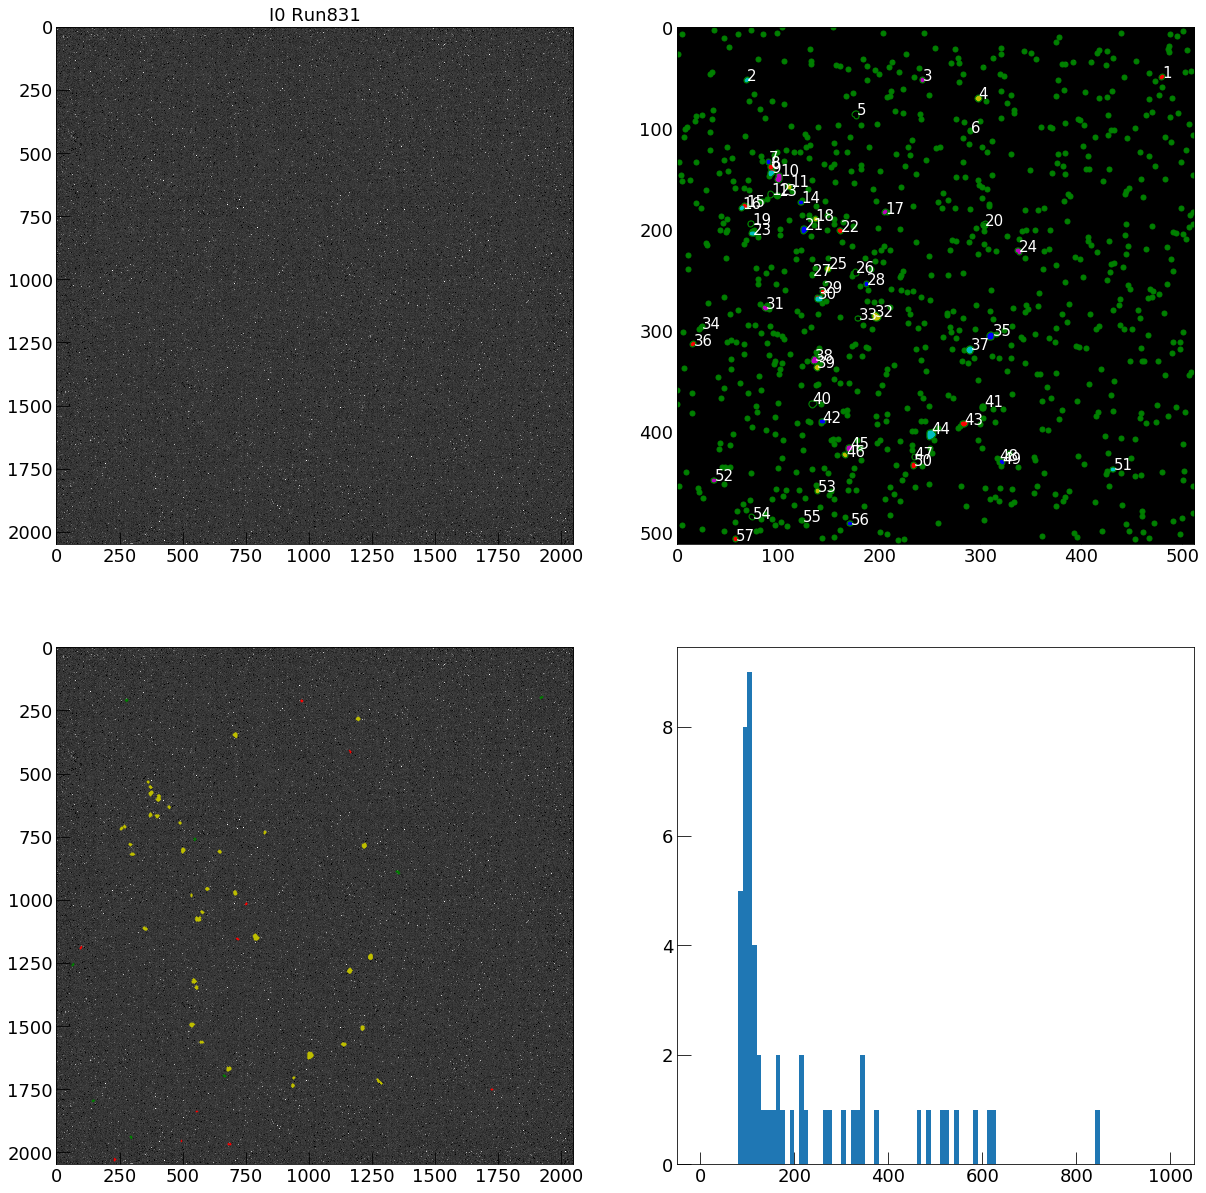

None

In [ ]:
cy.set_atlas_style('large')
############# Data in imput #######################################
dataSelection = 'LAB'
#
# runI = [340] # iTr = 10; max_image_to_read = 110
#
runI = [828, 827, 826, 825, 824, 823] # 834, 823, 835, 848, 860, 730, 340
runI = [835]
runI = [831]

run_ped = 818
############
debug  = True
files = ""
################ analysis cards ################################
nsigma       = 1         # numero di sigma sopra il piedistallo
cimax        = 150       # valori del cut sull'imagine
iTr          = 0        # traccia di partenza
rescale      = 512       # binnagio finale immagine (deve essre un sottomultipli della 2**2 risluzione di partenza)
minClose     = 2         # minimum cluser size (rebinne image)
maxClose     = 30000     # massima dimesione del clustr evita le scriche      
Cmethod      = 'nccs'    #'hdbs' # 'nccs'
max_image_to_read = 0  # 0 all
############### Inzializzazione varibili e costanti #################
scale        = int(x_resolution/rescale)
SumLight     = SumBck = SumPixel = 0.0
pClose       = 0
pixelCut     = 0
# MAIN LOOP ON 

for nRi in range(0,len(runI)):
    
    max_image=np.size(cy.swift_listdir(cy.file2FullPathCygnus(dataSelection, runI[nRi], 'H5')))
    print ("# of Image Files: %d" % (max_image))
    if max_image_to_read != 0:
        max_image = max_image_to_read   
    print ("WARNING: data will be anlyzed from %d to %d" % (iTr, max_image))

    if max_image == 0:
        print ("No file or image for file %s" % runI[nRi])
        print ("STOP")
        break

    #
    # load pedestal value generated by runs-pedestals.ipynb script
    # 
    try:
        fileoutm = ("./data/run%d_mean.h5" % (run_ped))
        m_image = cy.read_image_h5(fileoutm)
        PedOverMax = m_image[m_image > cimax].size
        print ("Pedestal mean: %.2f, sigma: %.2f, over th. (%d) %d" % 
           (m_image[m_image<cimax].mean(), 
            np.sqrt(m_image[m_image<cimax].var()), cimax,
            (m_image>cimax).sum()))
    except:
        print ("No Pedestal file for run %s, run script runs-pedestals.ipynb" % run_ped)
        print ("STOP")
        break
    try: 
        fileouts = ("./data/run%d_sigma.h5" % (run_ped))
        s_image = cy.read_image_h5(fileouts)
        print ("Sigma mean: %.2f, sigma: %.2f, over th. (50) %d" % 
       (s_image[s_image<50].mean(), 
        np.sqrt(s_image[s_image<50].var()), 
        (s_image>50).sum()))
    except:
        print ("No Sigma file for run %s, run script runs-pedestals.ipynb" % run_ped)
        print ("STOP")
        break

        
    #
    # Run by run init 
    #
    th_image   = np.round(m_image + nsigma*s_image) # verficare con il np.round.... np.ceil
    # th_image[:,:]=101 # per imostare tutto a 101
    data   = [] # output data 
    TrOk   = 0
    dCloseT= 0
    C      = np.zeros(0)
    poiE   = np.zeros(0)
    poiG   = np.zeros(0)
    poiN   = np.zeros(0)
    t0 = time.time()
    col    = ('b.', 'r.', 'c.', 'm.', 'y.', 'k.', 'g.') # sostituire g con k se si vogliono anche i singoli
    hL     = cy.Hist1D(200, 6000, 8000)
    hB     = cy.Hist1D(200, 6000, 8000)
    hP     = cy.Hist1D(int(scale*scale)*2, 0, int(scale*scale)*2)
    hLP    = cy.Hist1D(300, 80, 380)
    hBP    = cy.Hist1D(300, 80, 380)
    hLBP   = cy.Hist1D(30, 0, 30)
    hLS    = cy.Hist1D(cimax-80, 80, cimax)
    hLBPS  = cy.Hist1D(40, -10, 30)
    hLBPSe = cy.Hist1D(40, -10, 30)
    hLBPSg = cy.Hist1D(40, -10, 30)
    hLBPSn = cy.Hist1D(40, -10, 30)
    luceB = cy.Hist1D(100, 0, 1000)

    #################################
    # MAIN LOOP ON RUN
    ##################################
    
    while True:
        try:

            bad             = False
            image           = cy.swift_read_image_h5(cy.imageFile2FullPathCygnus(dataSelection, runI[nRi], iTr)) 
            edges_image     = (image > th_image) & (image < cimax)
            rebin_image     = cy.rebin(image, (rescale, rescale))
            rebin_th_image  = cy.rebin(th_image, (rescale, rescale))
            edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
            points          = np.array(np.nonzero(edges)).T.astype(float) 

            # print (image.sum(), m_image.sum(), image[image> cimax].size, )
            
            if image[image> cimax].size<1000000: # limit on the number og pixel over high cutof
                t0 = time.time()
                C = cy.clusteringWithMethod(points, minClose, Cmethod)
                
                print ("Clustering time: %.2f s" % (time.time()-t0))
                dCloseT, iCloseT, infoCloseT = cy.ClusteringInfo(C)
                if dCloseT < maxClose:

                    poiE = []
                    poiG = []
                    poiN = []
                    CiGood = 0
                    for Ci in range (0, len(infoCloseT)): # numebr of clusters found in the image
                        pClose = len(infoCloseT[Ci])      # size of clusters found
                        if pClose >= minClose:            # check closnnes
                            SumLight = SumBck = SumPixel = 0.0

                            for i in range(0, pClose):    # loop on single cluster value
                                x0      = int(C[infoCloseT[Ci]][i,2]*scale)
                                y0      = int(C[infoCloseT[Ci]][i,3]*scale)

                                SumPixel  += edges_image[(y0):(y0+scale),(x0):(x0+scale)].sum()
                                if SumPixel==0:
                                    print (">>> ERROR: Image: %d, cluster index: %d, size: %d" 
                                           % (iTr, Ci, pClose))
                            
                                SumLight += image[(y0):(y0+scale),(x0):(x0+scale)].sum()
                                
                                SumBck   += m_image[(y0):(y0+scale),(x0):(x0+scale)].sum()

                                
                            hL.fill(SumLight)                 # light in the cluster
                            hB.fill(SumBck)                   # background in the cluster
                            hP.fill(SumPixel)                 # pixels in the cluster
                            hLP.fill(SumLight / SumPixel)     # light per pixels in the cluster
                            hBP.fill(SumBck / SumPixel)       # beckground per pixels in the cluster
                            ph_media = (SumLight - SumBck) / SumPixel 
                            hLBP.fill(ph_media)               # photons per pixels in the cluster
                            luceB.fill(SumLight - SumBck)     # light-beckground in the cluster

                            x0m = y0m = 0
                            x0s = y0s = 0
                            n0  = 0
                       
                            for i in range(0, pClose):
                                x0   = int(C[infoCloseT[Ci]][i,2])*scale
                                y0   = int(C[infoCloseT[Ci]][i,3])*scale
                                if i == 0:
                                    x0start = x0 
                                    y0start = y0
                                for ny in range (y0, y0+scale):
                                    for nx in range (x0, x0+scale):
                                        if edges_image[ny, nx]:
                                            x0m     += nx
                                            y0m     += ny
                                            x0s     += nx**2
                                            y0s     += ny**2
                                            if n0 == 0:
                                                dex = dsx = nx
                                                dsy = dey = ny
                                            n0      += 1
                                            dsx      = min(dsx, nx)
                                            dsy      = min(dsy, ny)
                                            dex      = max(dex, nx)
                                            dey      = max(dey, ny)

                                            
                                            hLS.fill(image[ny, nx])
                                            
                                            ph = image[ny, nx] - m_image[ny, nx]
                                            hLBPS.fill(ph)
                                            
                                            if     ph_media <=10: # yellow (3)

                                                hLBPSe.fill(ph)
                                                if debug:
                                                    poiE.append([nx,ny])
                                            if 10 < ph_media <=15: # green (3:8)
                                                hLBPSg.fill(ph) 
                                                if debug:
                                                    poiG.append([nx,ny])
    
                                            if     ph_media > 15: # red (8)
                                                hLBPSn.fill(ph)
                                                if debug:
                                                    poiN.append([nx,ny])
                            if n0 > 1:
                                x0m = int(x0m / n0)
                                y0m = int(y0m / n0)
                                x0s = np.sqrt((x0s - x0m**2 * n0) / (n0 - 1))
                                y0s = np.sqrt((y0s - y0m**2 * n0) / (n0 - 1))

                            ddx = dex-dsx
                            ddy = dey-dsy
                            x0end = x0 
                            y0end = y0

                            ############
                            if debug:
                                nplot = 4
                                zoom = 40
                                if CiGood/nplot**2 == int(CiGood/nplot**2):
                                    if CiGood>0:
                                        plt.show()
                                    fig, axj = plt.subplots(nplot, nplot)
                                    xpi = 0
                                    ypi = 0
    
                    
                                #axj[xpi, ypi].imshow(edges_image[(y0m-zoom):(y0m+zoom),(x0m-zoom):(x0m+zoom)], 
                                #                     cmap="gray", vmin=0,vmax=1)
                                im = axj[xpi, ypi].imshow(image[(y0m-zoom):(y0m+zoom),(x0m-zoom):(x0m+zoom)], 
                                                     vmin=95,vmax=110)
                                #fig.colorbar(im, axj[xpi, ypi])
                                axj[xpi, ypi].plot(zoom, zoom, 'g.', markersize=13)
                                cir = plt.Circle((zoom, zoom), min(x0s, y0s)/2., 
                                                 color='r', linewidth=2, fill=False)
                                axj[xpi, ypi].add_artist(cir)
                                axj[xpi, ypi].plot([zoom-ddx/2, zoom+ddx/2], [zoom, zoom], 
                                                   'k-', linewidth=2)
                                axj[xpi, ypi].plot([zoom, zoom], [zoom-ddy/2, zoom+ddy/2], 
                                                   'k-', linewidth=2)
                                #axj[xpi, ypi].set_title("%d, %d, %d, (%d, %d) %.1f, %.1f" % 
                                #                        (Ci, pClose, SumPixel, x0m, y0m, x0s, y0s))
                                try: 
                                    dly = ddx/ddy
                                except:
                                    dly = 0.0
                                axj[xpi, ypi].set_title("%d, P: %d, Ph: %d, R: %.1f" % 
                                                        (Ci, SumPixel, SumLight-SumBck, dly))
                                ypi +=1
                                CiGood +=1
                                if ypi == nplot:
                                    ypi = 0
                                    xpi +=1
                            ###########                            
     
                            data.append([iTr, TrOk, SumLight, SumBck, SumPixel, 
                                         pClose, x0m, x0s, y0m, y0s, ddx, ddy, x0start, y0start, x0end, y0end])
                            TrOk+=1

                else:
                    print ('>>> Imagine not Anayzed (to many clusters): %d, Tracce: %d, luce: %d Clustering: %d' % 
                                      (iTr, TrOk,  image.sum(), dCloseT))
                    bad   = True
            else:
                print ('>>> Imagine not Clastered (to many point over th): %d, Tracce: %d, luce: %.2e, %d, %d' % 
                                      (iTr, TrOk,  image.sum(), image[image> cimax].size, PedOverMax))
                bad   = True
                
        
            if debug:
                print ("Cluster Size: %d" % (dCloseT))
                fig, ax = plt.subplots(2,2)
                ax[0,0].imshow(image, cmap="gray", vmin=85,vmax=150)
                ax[0,0].set_title("I%d Run%d" % (iTr, runI[nRi]))
                ax[0,1].imshow(edges, cmap="gray", vmin=0,vmax=1)
                ax[0,1].plot(points[:,1], points[:,0], 'g.', markersize=10)
                NCL  = 0
                ncol = 0
                for i in range(0, len(C)):
                    if C[i,1]>0:
                        if C[i,1]==1:
                            NCL +=1
                            ncol +=1
                            if ncol>6:
                                ncol = 0
                            ax[0,1].annotate(("%d"%(NCL)), (C[i,2]+1, C[i,3]+1), color='white', size=15)
                        ax[0,1].plot(C[i-1,2], C[i-1,3], col[ncol], markersize=5)
                        ax[0,1].plot(C[i,2], C[i,3], col[ncol], markersize=5)
                ax[1,0].imshow(image, cmap="gray", vmin=85,vmax=150)
                poiE = np.array(poiE)
                poiG = np.array(poiG)
                poiN = np.array(poiN)
    
                if poiE.any():
                    ax[1,0].plot(poiE[:,0], poiE[:,1], 'y.', markersize=1)
                if poiG.any():
                    ax[1,0].plot(poiG[:,0], poiG[:,1], 'g.', markersize=1)
                if poiN.any():
                    ax[1,0].plot(poiN[:,0], poiN[:,1], 'r.', markersize=1)

                ax[1,1].bar(np.array(luceB.data[0]),np.array(luceB.data[1]), 10, align='center')
                #ax[1,1].step(*luceB.data)
                #ax[1,1].step(*hLBPS.data)
                # resetta i grafici in caso del solo debug per l'anlisi imagine per imagine
                hLS    = cy.Hist1D(cimax-80, 80, cimax)
                #hLBPS  = cy.Hist1D(100, -20, 30)
                #hLBPSe = cy.Hist1D(100, -20, 80)
                #hLBPSg = cy.Hist1D(100, -20, 80)
                #hLBPSn = cy.Hist1D(100, -20, 80)
                #luceB  = cy.Hist1D(100, 0, 1000)
            if iTr/10.0 == int(iTr/10.0):
                print ('Iamege: %d, Spot: %d, Light: %d bck: %d' % 
                       (iTr, TrOk,  image.sum(), m_image.sum()))
            if debug:
                display.display(plt.show())
                display.clear_output(wait=True)
        
            if iTr == max_image-1:
                break
            iTr+=1
            if not bad:   
                bad = False
            if debug:
                input('Press <ret> to continue -> ')
            print ("Dt: %.2e, %d, %d, %d, %d"% (time.time()-t0, SumLight, SumBck, SumPixel, Ci))
        except KeyboardInterrupt:
            break
    if not debug:
        files = ("./data/clustering_run%d_Nsig_%d_Mcut_%d_Pcut_%d_scale_%d_close_%d_%s.txt" % 
                 (runI[nRi], nsigma, cimax, pixelCut, scale, minClose, Cmethod))
        np.savetxt(files, data, fmt='%.10e', delimiter=" ")
    print ("ENDED - Out on File: %s" % files)
    iTr  = 0 #reset teck for next file


In [ ]:
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from scipy.stats import norm
cy.set_atlas_style()
y        = np.array(luceB.data[1])
x        = np.array(luceB.data[0])

plt.bar(x,y, 10, align='center')
plt.title("light-beckground in the cluster")
plt.show()
y        = np.array( hL.data[1])
x        = np.array( hL.data[0])

plt.bar(x,y, 10, align='center')
plt.title("light in the cluster")
plt.show()
plt.show()
y        = np.array( hB.data[1])
x        = np.array( hB.data[0])

plt.bar(x,y, 10, align='center')
plt.title("background in the cluster")
plt.show()
y        = np.array( hP.data[1])
x        = np.array( hP.data[0])

plt.bar(x,y, 1, align='center')
plt.title("pixels in the cluster")
plt.show()
y        = np.array( hLP.data[1])
x        = np.array( hLP.data[0])

plt.bar(x,y, 1, align='center')
plt.title("light per pixels in the cluster")
plt.show()
plt.show()
y        = np.array( hBP.data[1])
x        = np.array( hBP.data[0])

plt.bar(x,y, 1, align='center')
plt.title("beckground per pixels in the cluster")
plt.show()

y        = np.array( hLBP.data[1])
x        = np.array( hLBP.data[0])

plt.bar(x,y, 1, align='center')
plt.title("photons per pixels in the cluster")
plt.show()

In [13]:
plt.Circle((x0m, y0m), 5, color='r', fill=False)
plt.show()